# Unsupervised learning: Clustering 

* This notebook is a modified version of the clustering notebook used in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html).

In [1]:
## Preamble / required packages
import numpy as np
import scipy.sparse as sp
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Unsupervised learning

+ Two major types of unsupervised learning: clustering and dimensionality reduction (embedding).
+ Clustering: grouping similar data points together, based on their features.
+ Dimensionality reduction: mapping high-dimensional data to a lower-dimensional space, for visualization or for further analysis

Here, we will deal with a very high-dimensional dataset (many features per datapoint). We will first use embedding to reduce the dimensionality of the dataset, and we will then use clustering to group datapoints in the lower dimensional space. Importantly, we don't always have to use embeddings and clusterings together---we might embed data for other reasons (like visualization), or we might choose to cluster data in high dimensions

+ Important: in unsupervised learning, we do *not* use labels when fitting our model. The methods look for structure within the data itself. However, if we do have labels, we can compare them to the known structure, to see how well the clustering algorithm performs. 
+ Sometimes the outputs of an unsupervised learning algorithm are called "pseudolabels" because they are not the true labels, but they can be used as a proxy for true labels in a downstream supervised learning analysis. Some methods leverage a small amount of labelled data to tune an unsupervised learning algorithm, which in turn is used to produce pseudolabels for a large amount of data. This allows supervised learning methods to be trained on larger datasets than would otherwise be accessible. Collectively these methods are known as "semi-supervised" learning methods.

## Ising Dataset

We now explore how to cluster the Ising dataset and visualize the results using PCA. The raw Ising dataset was generated via Monte Carlo simulations, and it contains snapshots of microstates at a temperature where the system is mostly ordered, a temperature where it is mostly disordered, and a temperature in the critical transition region. 

First let's load the Ising dataset:

In [2]:
import pickle, os
from urllib.request import urlopen
import pickle,os
def fetch_data():
    """
    Retrieve Ising dataset from the web and load into a numpy array

    The data is stored in a binary format in order to maximize its compressibility, but
    we need to convert the zeros to -1 to match the Ising model conventions.

    Returns:
        X_all (np.array): 2D array of shape (N, 2**L) where N is the number of samples, 
            corresponding to a list of Ising microstates
        y_all (np.array): 1D array of shape (N,) corresponding to the temperature of
            each microstate
    """

    ## URL of data
    url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
    # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
    data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
    # The labels are obtained from the following file:
    label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

    # Load dataset into numpy
    # pickle reads the file and returns the Python object (1D array, compressed bits)
    X_all = pickle.load(urlopen(url_main + data_file_name))  
    
    # Decompress array and reshape for convenience
    X_all = np.unpackbits(X_all).reshape(-1, 1600)
    X_all = X_all.astype("int")
    # map 0 state to -1 (Ising variable can take values +/-1)
    X_all[np.where(X_all == 0)] = -1

    y_all= np.hstack([t]*10000 for t in np.arange(0.25, 4.01, 0.25)) # Temperature values for each sample
    return X_all, y_all




In [4]:
## Load all data
X, y = fetch_data()

## Randomly subsample the data 

np.random.seed(0) # fix the random seed
idx = np.arange(len(X))
rand = np.random.choice(idx, size=8000, replace=False)

X_batch, y_batch = X[rand], y[rand]

### Fit embeddings and plot the results

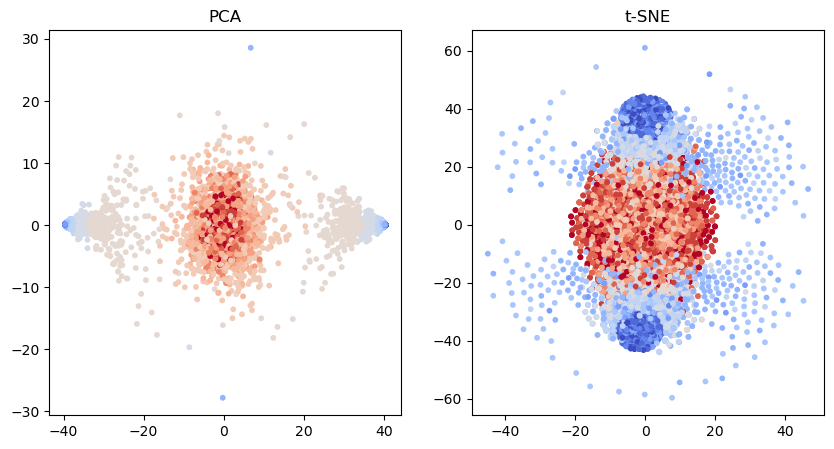

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Fit PCA and t-SNE embedding methods
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_batch)
component1 = pca.components_[0]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_batch)

## Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_batch, s=10, cmap="coolwarm")
ax[0].set_title("PCA")
ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_batch, s=10, cmap="coolwarm")
ax[1].set_title("t-SNE")
plt.show()

We see that that three clusters are found. We can also inspect the PCA-1 principal component:

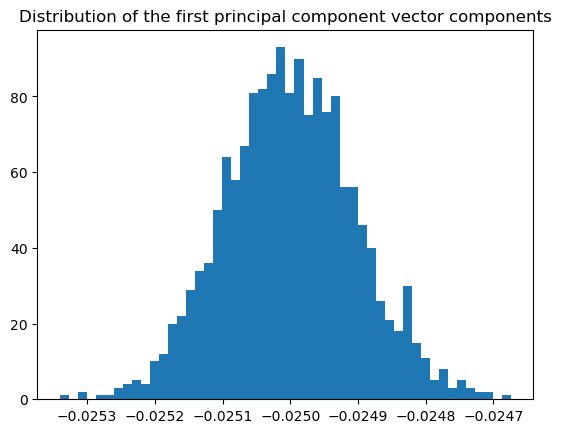

In [7]:
plt.hist(component1, bins=50)
plt.title('Distribution of the first principal component vector components')
plt.show()

### Discussion

The components of the first PCA vector are tightly distributed around a single value. This implies that the PCA vector is essentially a constant vector. Indeed it corresponds to the magnetization order parameter. The first component yields the magnetization order parameter because PCA finds linear combinations of the features that have the largest variance. Clearly the magnetization satisfies this condition (since it goes from 0 to 1 as temperature is varied).

# K means clustering

We will now use the $K$-means algorithm to cluster the Ising data. The $K$-means algorithm is a simple algorithm that is easy to implement and understand. It is also very fast. The algorithm is as follows:

1. Choose $K$ initial cluster centers
2. Assign each point to the nearest cluster center
3. Update the cluster centers to be the mean of the points in the cluster
4. Repeat steps 2 and 3 until the cluster centers do not change

The $K$-means algorithm is guaranteed to converge to a local minimum. However, the choice of initial cluster centers can lead to different results.

Unlike some other clustering methods, the KMeans algorithm requires that we specify the number of clusters $K$ in advance as a hyperparameter. However, there are external heuristics like the silhouette score that we cane use to determine the optimal number of clusters.

In [33]:
class KMeansClusterer:
    """
    An implementation of the K Means clustering algorithm.
    """

    def __init__(self, n_clusters=2, max_iter=100, tol=1e-4, store_history=False, random_state=None):
        """
        Initialize a KMeansClusterer object.

        Args:
            n_clusters (int): number of clusters to fit
            max_iter (int): maximum number of iterations to run
            tol (float): tolerance for convergence
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.store_history = store_history
        self.random_state = random_state

    def fit(self, X):
        """
        Fit the KMeans clustering algorithm to the data.

        Args:
            X (np.array): 2D array of shape (N, D) containing the data to cluster

        Returns:
            self (KMeansClusterer): the fitted KMeansClusterer object
        """
        N, D = X.shape

        ## Initialize the cluster centers and assign all points to the first cluster
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.centers = np.random.choice(N, size=self.n_clusters, replace=False)
        self.centers = X[self.centers]
        self.labels = np.zeros(N)

        if self.store_history:
            self.history = []
            self.loss_history = []
            self.label_history = []

        for i in range(self.max_iter):

            ## Assign each point to the nearest cluster center
            distortion = np.sum((X[:, np.newaxis, :] - self.centers[np.newaxis, :, :]) ** 2, axis=2)
            self.labels = np.argmin(distortion, axis=1)

            if self.store_history:
                self.history.append(self.centers)
                self.loss_history.append(np.mean(np.min(distortion, axis=1)))
                self.label_history.append(self.labels.copy())

            ## Update the cluster centers based on the latest assignments
            new_centers = np.array([np.mean(X[self.labels == j], axis=0) for j in range(self.n_clusters)])

            ## Stop if the centers have converged
            if np.sum((new_centers - self.centers) ** 2) < self.tol:
                print("Converged after {} iterations".format(i))
                break
            self.centers = new_centers



        return self

    def predict(self, X):
        """
        Predict the labels of the data.

        Args:
            X (np.array): 2D array of shape (N, D) containing the data to cluster

        Returns:
            labels (np.array): 1D array of shape (N,) containing the predicted labels
        """
        return np.argmin(np.sum((X[:, np.newaxis, :] - self.centers[np.newaxis, :, :]) ** 2, axis=2), axis=1)

    def fit_predict(self, X):
        """
        Fit the KMeans clustering algorithm to the data and predict the labels.

        Args:
            X (np.array): 2D array of shape (N, D) containing the data to cluster

        Returns:
            labels (np.array): 1D array of shape (N,) containing the predicted labels
        """
        self.fit(X)
        return self.predict(X)
        

Converged after 4 iterations


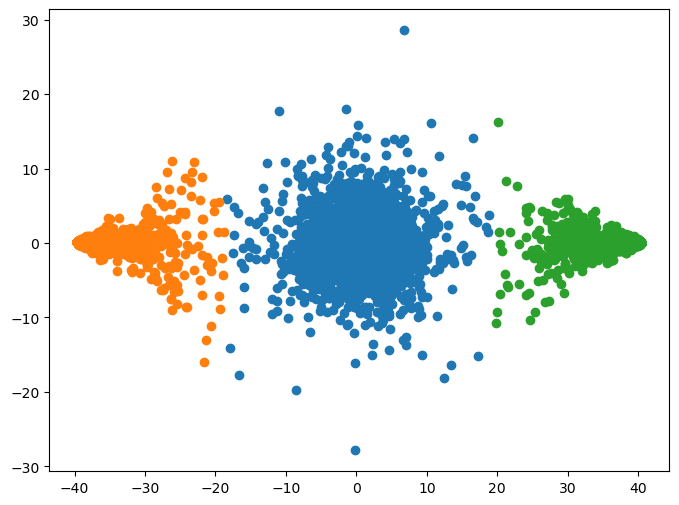

Text(0, 0.5, 'Loss (Inertia)')

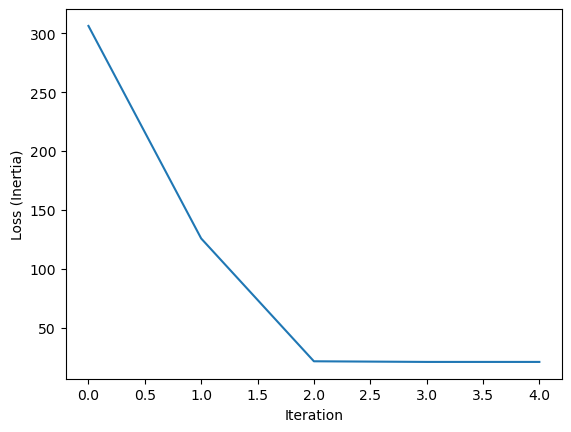

In [34]:
model = KMeansClusterer(n_clusters=3, max_iter=100, tol=1e-4, store_history=True, random_state=14)
labels = model.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
for label_val in np.unique(labels):
    plt.scatter(X_pca[labels==label_val, 0], X_pca[labels==label_val, 1])
plt.show()

plt.figure()
plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss (Inertia)')


[array([0, 2, 2, ..., 1, 1, 2]),
 array([0, 0, 2, ..., 1, 1, 2]),
 array([0, 0, 2, ..., 1, 1, 2]),
 array([0, 0, 2, ..., 1, 1, 2]),
 array([0, 0, 2, ..., 1, 1, 2])]

In [40]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    plt.figure(figsize=(8, 6))
    labels = model.label_history[i]
    for label_val in np.unique(labels):
        plt.scatter(X_pca[labels==label_val, 0], X_pca[labels==label_val, 1])
    plt.plot(*model.history[i].T, '.k', markersize=20)
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=4), Output()), _do…

<function __main__.plotter(i)>

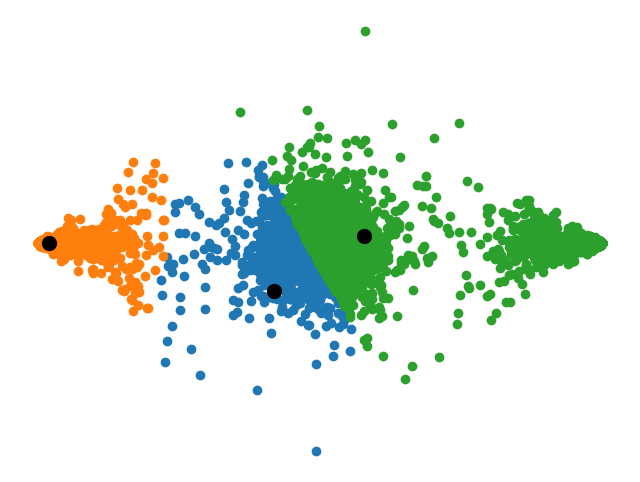

<Figure size 200x200 with 0 Axes>

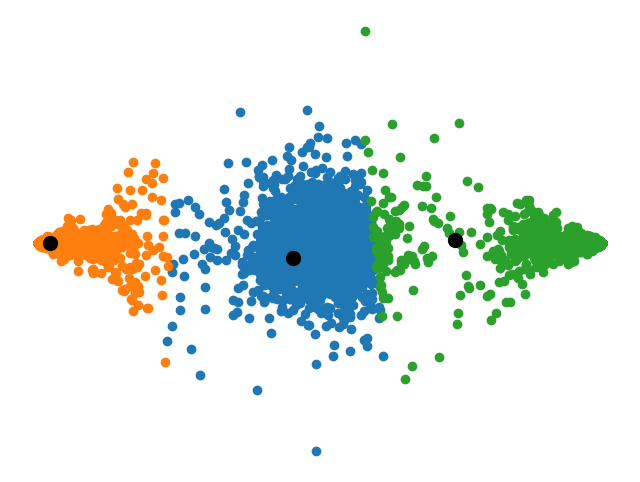

<Figure size 200x200 with 0 Axes>

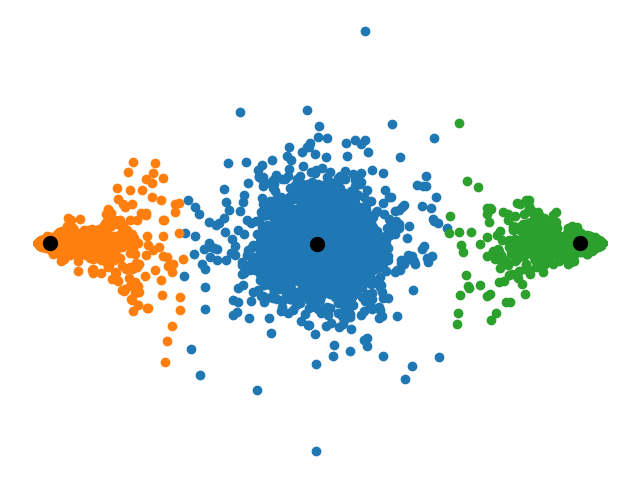

<Figure size 200x200 with 0 Axes>

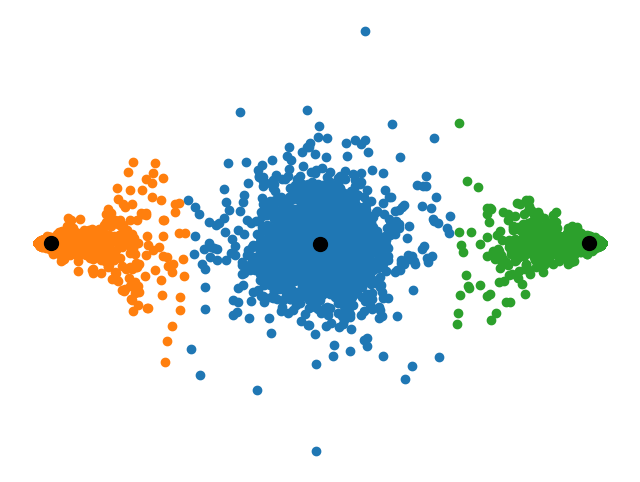

<Figure size 200x200 with 0 Axes>

In [45]:
## plot a static version of the sliders above

for i in range(len(model.history) - 1):
    plotter(i)
    plt.gcf().set_size_inches(2, 2, forward=True)
    

### Are the observed clusters physically meaningful?

Let's now look at the mean of each cluster. Since we have obtained the cluster labels, we can go back to the original space, rather the lower dimensional PCA space that we have been working in so far

In [124]:
[np.mean(X_batch[labels==label_val]) for label_val in [0, 1, 2]]

[0.9542431850789096, -0.9580437178545187, -0.00042316258351893097]

Thus we found that left- and right-most clusters are well magnetized (ordered phase). The middle cluster is not magnetized and corresponds to the high-temperature states.

# Clustering accuracy and clustering algorithm parameters:

+ We want to use clustering to explore datasets where we don't have labels. However, for the Ising dataset, we do have labels in the form of temperatures at which simulations were completed. 

1. Can we use these labels to define what a good cluster or a good clustering assignment is?
2. For cases where we don't have access to labels, how would we determine if a clustering algorithm is doing a good job?


One way to quantitatively measure the performance of a clustering method is to compare the predicted labels to the ground-truth labels (given that those are available). Here we will use the normalized mutual information (see https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html for more discussion on the subject and other possible metrics) to perform such comparison. As we will see, when doing clustering, there is usually no free lunch: if one chooses the wrong set of parameters (which can be quite sensitive), the clustering algorithm will likely fail or return a trivial answer (for instance all points assigned to the same cluster).  

In [126]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.0
    for kc in c.keys():
        p=len(c[kc]) / n_sample
        h += p * np.log(p)
    h *= -1.0
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample * w_intersect_c/(len(w[kw]) * len(c[kc])))
    Iwc /= n_sample
    Hc = entropy(c, n_sample)
    Hw = entropy(w, n_sample)

    return 2 * Iwc / (Hc + Hw)

## Try other clustering methods

This code is adapted from [the scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

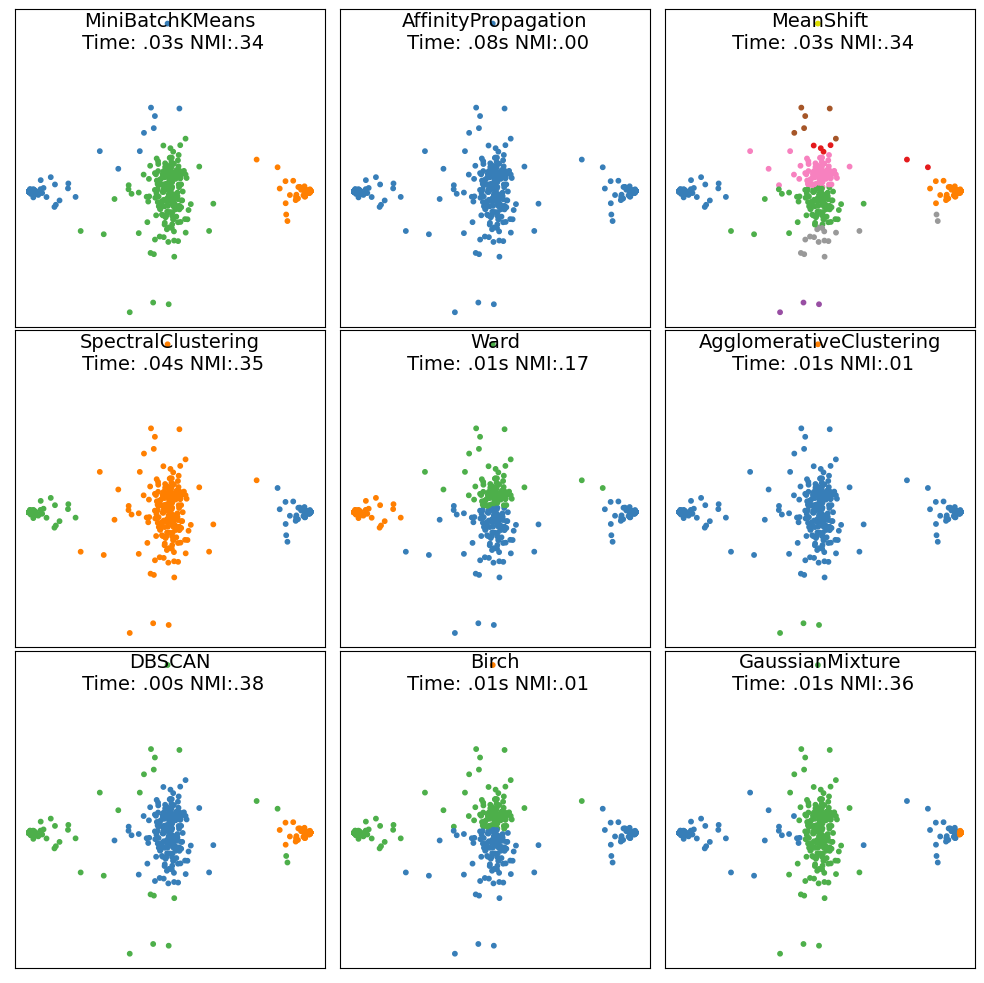

In [131]:
import time
import warnings


from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


np.random.seed(0)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

algo_params = {'damping': .9, 'preference': -240, 'quantile': .2, 'n_clusters': 3}
i_dataset = 0

# for i_dataset, (dataset, algo_params) in enumerate(datasets):

# update parameters with dataset-specific values
params = default_base.copy()
params.update(algo_params)

X_batch, y_batch = X_pca[:400], y_batch[:400]
# y_batch = tt

# normalize dataset for easier parameter selection
X_batch = StandardScaler().fit_transform(X_batch)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X_batch, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X_batch, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm)
)

for i, (name, algorithm) in enumerate(clustering_algorithms):
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X_batch)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X_batch)

    score = NMI(y_batch, y_pred)

    # if i_dataset == 0:
    #     plt.title(name, size=14)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1))))

    plt.subplot(3, 3, i+1)

    plt.scatter(X_batch[:, 0], X_batch[:, 1], s=10, color=colors[y_pred])
    plt.xticks(())
    plt.yticks(())

    plt.title(name + "\n Time: " + ("%.2fs" % (t1 - t0)).lstrip("0") + " NMI:" + ("%.2f" % score).lstrip("0"), size=14, y=1.0, pad=-28)

# plt.show()

# Remarks and discussion

We can see that the NMI doesn't perfectly match our expectations. It rewards algorithms that assign more labels than are necessary to fully describe the dataset. For this reason, other metrics like the silhouette score or the adjusted rand index are sometimes used instead.

In this simple setting, DBSCAN outperforms the other methods both in computational time and in prediction accuracy for almost all cases. Only Spectral Clustering appears to perform better on the PCA-featurized Ising dataset. 

When tuning a clustering method it is important to understand what the implicit assumption of the clustering method are. For instance, methods based on density (local information), will typically fare well at clustering topological datasets, in which there is a distance metric relating different datapoints. Methods based on long-distance information ($K$-means for instance), will typically perform poorly in such instances. Density-based methods will, however, have more difficulty dealing with datasets with large fluctuations in the density distribution of the dataset. Another drawback of density based methods is that they do not generalize well to high-dimensional space due to large sampling noise in the density estimates. 

# Discussion

We see that $K$-Means does a great job at dealing with Gaussian mixtures of equal variances. The normalized mutual information is maximized at $K=15$. However, one usually does not have access to ground-truth labels. Many simple measures of clustering can be devised to measure clustering accuracy (for instance the distortion, see above). These however tend to be monotonic in the number of clusters. Maximizing/minimizing such metrics will lead 
to trivial solutions. Instead one usually tries to find a point of inflexion (or kink) in the metric, which signifies a major change in the clustering algorithm and can be sometimes associated with the regime of good solutions.

# Exercises
1. In the case where clusters are non-convex, do you think one can still use $K$-means to find good solutions?
2. How does $K$-means relate to latent variable models (where a probability is fitted to the data)?
3. In the case of non-convex clusters, can you think of a way of using $K$-means to yield good clustering assignments (hint : consider merging clusters)?

# Density based clustering: DBSCAN
Here we sweep over the main parameters of DBSCAN and compute the normalized mutual information for every assignment found.

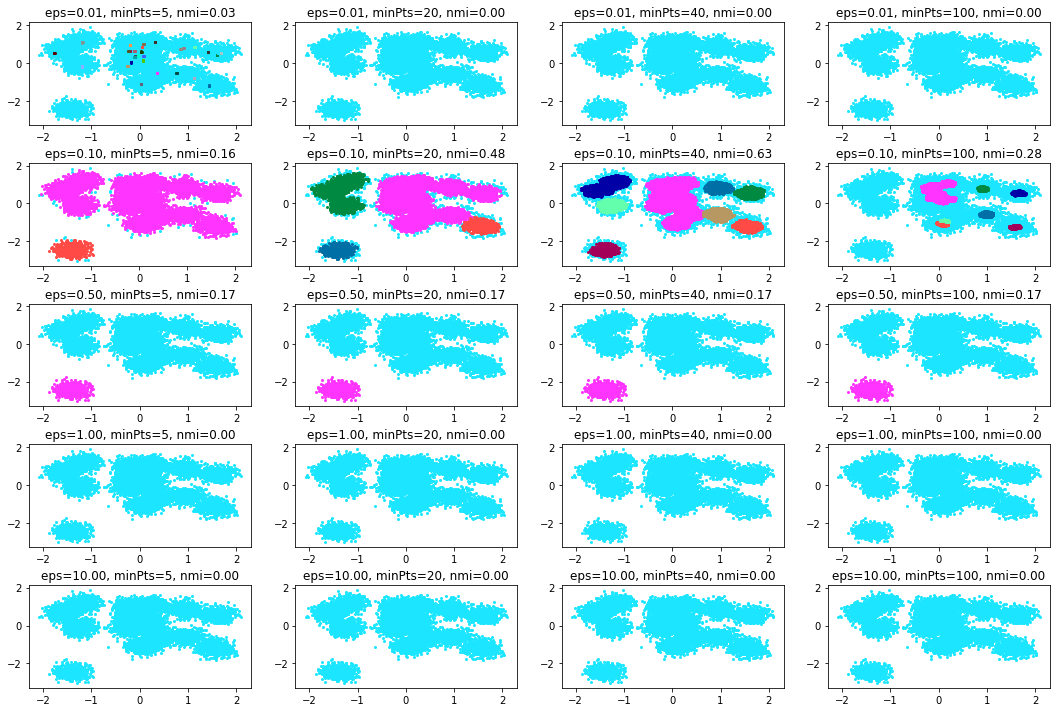

In [46]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(0)
n_true_center=15
X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

eps_range = [0.01,0.1,0.5,1.0,10.]
min_sample_range = [5,20,40,100]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()

# Discussion

### Parameters

DBSCAN does a great job of clustering when the parameters are well chosen. `minPts` is responsible for determining what an outsider is (i.e. if a point has less than `minPts` in its epsilon neighborhood, it is not a core-point). `eps` tunes the size of the neighborhood of each point which is just a circle of radius `eps`. 

### Number of clusters

Note also that obtaining the exact number of clusters or the perfect cluster assignment is usually not what is sought in clustering (since it is usually not possible to do this). Indeed, if two Gaussians (representing two different clusters) have a large overlap, the density function corresponding to the sum of the two Gaussians will effectively look like a single Gaussian and it makes sense to predict a unique cluster in this situation. Given the available information, there is no statistically significant way of separating those two clusters. This scale of separation, i.e. what to consider noise and what to consider distinct clusters, is usually encoded in one of the parameters of density based clustering algorithms.

# Exercises:

1. How would you estimate the density of a data point ?
2. Try and construct a density map of the dataset above. 
3. Visualize this density map by coloring each point with their density. Did you have to introduce a parameter that influences the density estimate ? In the case of DBSCAN, this would be the `eps` parameter.
4. (if yes !) Try changing this parameter and see how it changes the map. 
5. Can you tune this parameter such that the density map clearly shows 15 distinct clusters ?

# The importance of featurization: representing a time series dataset

In [ ]:
from scipy.integrate import solve_ivp


class DoublePendulum:

    def __init__(self):
        pass

    def rhs(self, t, x):
        """
        Right hand side of the double pendulum
        """
        x1, x2, x3, x4 = x
        x1dot = x2
        x2dot = -np.sin(x1) - 0.5 * np.sin(x1 - x3)
        x3dot = x4
        x4dot = np.sin(x1) - 0.5 * np.sin(x1 - x3)
        return np.array([x1dot, x2dot, x3dot, x4dot])

    def jac(self, t, x):
        """
        Jacobian of the double pendulum
        """
        x1, x2, x3, x4 = x
        J = np.array([
            [0, 1, 0, 0],
            [-np.cos(x1), 0, 0.5 * np.cos(x1 - x3), 0],
            [0, 0, 0, 1],
            [np.cos(x1), 0, -0.5 * np.cos(x1 - x3), 0]
        ])
        return J

    def integrate(self, x0, t0, tf, dt):
        """
        Integrate the double pendulum
        """
        t = np.arange(t0, tf, dt)
        x = np.zeros((len(t), 4))
        x[0] = x0
        sol = solve_ivp(self.rhs, (t0, tf), x0, t_eval=t, method='RK45')
        return sol.t, sol.y.T
        # for i in range(1, len(t)):
        #     x[i] = x[i-1] + dt * self.rhs(t[i-1], x[i-1])
        # return t, x

model = DoublePendulum()
t, x = model.integrate(x0=[0, 0.5, 0.4, 0], t0=0, tf=200, dt=0.005)
plt.plot(x[:, 0], x[:, 1])







# Featurization

We want to choose features that we suspect will summarize each dataset in an illustrative way. 

+ Time series: For time series, often the clustering should be invariant to time shifts. As a result, features resulting from integral transforms (like coefficients of various Fourier modes) are usually better choices for features than individual timepoints

In [ ]:
## A more sophisticated featurization: tsfresh

# Import the required packages
import tsfresh

# Import the data


In [ ]:
LightGBM
XGBOOST

HCBSCAN

Semi-supervised